### 2. RQ1: CHEATING BEHAVIOR ANALYSIS

Answers these two research questions ~
- #### RQ1a: Do concept-based interventions reduce cheating behavior?
- #### RQ1b: Do the effects on cheating vary by concepts?


We do this by:
- (2.1) Fits Bayesian multinomial logistic regression (3 cheating categories)
    - Controls for motivational message variations through random effects
    - Uses empirical priors from control group baseline rates
    - Tests 15 intervention concepts across 4 psychological theories
    - Provides diagnostic checks for model fit and convergence in 2.1.1
- (2.2) Analyzes model results to answer RQ1a and RQ1b
    - Produces Figure: Overall intervention effects
    - Produces Figure: Concept-specific effects

In [1]:
# =============================================================================
# 1. SETUP AND DATA PREPARATION
# =============================================================================

import sys, os, warnings
sys.path.append('../')
warnings.filterwarnings('ignore')
os.chdir('game-behavior-analytics/data_analysis_notebook/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

# Load and prepare data
df = pd.read_csv("../data/final_dataset.csv")

def categorize_cheating(rate):
    return 0 if rate == 0 else 2 if rate == 1 else 1

# Create analysis variables
df['cheating_behavior'] = df['cheating_rate_main_round'].apply(categorize_cheating)
df['experience'] = (df['task_satisfaction'] + df['task_engagement']) / 2
df['performance'] = df['performance_score_including_cheated_words']
df = df.dropna(subset=['cheating_behavior', 'performance', 'experience', 'concept'])

# Prepare categorical variables
concept_ids = df['concept'].astype('category')
if concept_ids.cat.categories[0] != 'control':
    concept_ids = concept_ids.cat.reorder_categories(['control'] + [c for c in concept_ids.cat.categories if c != 'control'])

concept_codes = concept_ids.cat.codes.values
concepts = [c for c in concept_ids.cat.categories if c != 'control']

# Create nested message structure: concept -> messages
message_df = df[['concept', 'motivational_message_id']].drop_duplicates()
concept_message_map = {}
for concept in concept_ids.cat.categories:
    messages = message_df[message_df['concept'] == concept]['motivational_message_id'].unique()
    concept_message_map[concept] = {msg: i for i, msg in enumerate(messages)}

# Create nested message indices
df['concept_idx'] = concept_codes
df['message_within_concept'] = df.apply(
    lambda row: concept_message_map[row['concept']][row['motivational_message_id']], axis=1
)

print(f"Dataset: {len(df)} participants")
print(f"Control: {sum(concept_codes == 0)}, Intervention: {sum(concept_codes > 0)}")
print(f"Concepts: {len(concepts)}, Total messages: {len(df['motivational_message_id'].unique())}")


Dataset: 1232 participants
Control: 73, Intervention: 1159
Concepts: 15, Total messages: 46


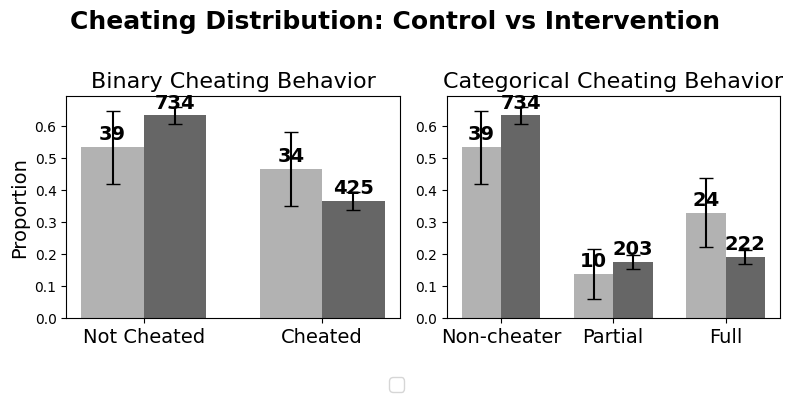

In [ ]:
# =============================================================================
# 2. DESCRIPTIVE ANALYSIS
# =============================================================================

def prop_ci(data, col, categories):
    """Calculate proportions with 95% confidence intervals"""
    n = len(data)
    props, ci_l, ci_u, counts = [], [], [], []
    for cat in categories:
        count = (data[col] == cat).sum()
        prop = count / n
        se = np.sqrt(prop * (1 - prop) / n)
        props.append(prop)
        ci_l.append(max(0, prop - 1.96 * se))
        ci_u.append(min(1, prop + 1.96 * se))
        counts.append(count)
    return props, ci_l, ci_u, counts

# Create visualization
control_data = df[df['concept'] == 'control']
intervention_data = df[df['concept'] != 'control']

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
bar_width, font_size = 0.35, 14

# Binary cheating plot
cats_binary = [0, 1]
df['cheated_binary'] = (df['cheating_behavior'] > 0).astype(int)
control_p, ci_l, ci_u, counts = prop_ci(control_data, 'cheated_binary', cats_binary)
interv_p, ci_l2, ci_u2, counts2 = prop_ci(intervention_data, 'cheated_binary', cats_binary)

x = np.arange(len(cats_binary))
bars1 = axes[0].bar(x - bar_width/2, control_p, bar_width, 
                   yerr=[np.array(control_p)-np.array(ci_l), np.array(ci_u)-np.array(control_p)],
                   capsize=5, label=f'Control (n={len(control_data)})', color='gray', alpha=0.6)
bars2 = axes[0].bar(x + bar_width/2, interv_p, bar_width,
                   yerr=[np.array(interv_p)-np.array(ci_l2), np.array(ci_u2)-np.array(interv_p)],
                   capsize=5, label=f'Intervention (n={len(intervention_data)})', color='black', alpha=0.6)

# Add count annotations
for bars, counts_list in zip([bars1, bars2], [counts, counts2]):
    for bar, count in zip(bars, counts_list):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    count, ha='center', va='bottom', fontweight='bold', fontsize=font_size)

axes[0].set_xticks(x)
axes[0].set_xticklabels(['Not Cheated', 'Cheated'], fontsize=font_size)
axes[0].set_title('Binary Cheating Behavior', fontsize=font_size + 2)
axes[0].set_ylabel('Proportion', fontsize=font_size)

# Categorical cheating plot  
cats_full = [0, 1, 2]
control_p2, ci_l3, ci_u3, counts3 = prop_ci(control_data, 'cheating_behavior', cats_full)
interv_p2, ci_l4, ci_u4, counts4 = prop_ci(intervention_data, 'cheating_behavior', cats_full)

x2 = np.arange(len(cats_full))
bars3 = axes[1].bar(x2 - bar_width/2, control_p2, bar_width,
                   yerr=[np.array(control_p2)-np.array(ci_l3), np.array(ci_u3)-np.array(control_p2)],
                   capsize=5, color='gray', alpha=0.6)
bars4 = axes[1].bar(x2 + bar_width/2, interv_p2, bar_width,
                   yerr=[np.array(interv_p2)-np.array(ci_l4), np.array(ci_u4)-np.array(interv_p2)],
                   capsize=5, color='black', alpha=0.6)

for bars, counts_list in zip([bars3, bars4], [counts3, counts4]):
    for bar, count in zip(bars, counts_list):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    count, ha='center', va='bottom', fontweight='bold', fontsize=font_size)

axes[1].set_xticks(x2)
axes[1].set_xticklabels(['Non-cheater', 'Partial', 'Full'], fontsize=font_size)
axes[1].set_title('Categorical Cheating Behavior', fontsize=font_size + 2)

fig.legend(*axes[1].get_legend_handles_labels(), loc='lower center', ncol=2, fontsize=font_size)
plt.suptitle('Cheating Distribution: Control vs Intervention', fontsize=font_size + 4, fontweight='bold')
plt.tight_layout(rect=[0, 0.1, 1, 0.96])
plt.show()


In [ ]:
# Raw percentage changes by concept vs control
control = df[df['concept'] == 'control']
control_props = control['cheating_behavior'].value_counts(normalize=True).sort_index() * 100

print("RAW PERCENTAGE CHANGES BY CONCEPT (vs Control)")
print("=" * 80)
print(f"{'Concept':<25} {'Non-cheater':<15} {'Partial':<15} {'Full':<15} {'n':<5}")
print("-" * 80)

# Control baseline
ctrl_non = control_props.iloc[0] if 0 in control_props.index else 0
ctrl_partial = control_props.iloc[1] if 1 in control_props.index else 0  
ctrl_full = control_props.iloc[2] if 2 in control_props.index else 0

print(f"{'Control (baseline)':<30} {ctrl_non:>6.1f}%        {ctrl_partial:>6.1f}%        {ctrl_full:>6.1f}%        {len(control):<5}")
print("-" * 80)

# Each concept vs control
for concept in df[df['concept'] != 'control']['concept'].unique():
    subset = df[df['concept'] == concept]
    props = subset['cheating_behavior'].value_counts(normalize=True).sort_index() * 100
    
    non_pct = props.iloc[0] if 0 in props.index else 0
    partial_pct = props.iloc[1] if 1 in props.index else 0
    full_pct = props.iloc[2] if 2 in props.index else 0
    
    # Calculate differences
    non_diff = non_pct - ctrl_non
    partial_diff = partial_pct - ctrl_partial
    full_diff = full_pct - ctrl_full
    
    concept_clean = concept.replace('_', ' ').title()
    print(f"{concept_clean:<30} {non_diff:>+6.1f}%       {partial_diff:>+6.1f}%       {full_diff:>+6.1f}%       {len(subset):<5}")


RAW PERCENTAGE CHANGES BY CONCEPT (vs Control)
Concept                   Non-cheater     Partial         Full            n    
--------------------------------------------------------------------------------
Control (baseline)               53.4%          13.7%          32.9%        73   
--------------------------------------------------------------------------------
Performance Accomplishments      +3.7%         +7.1%        -10.8%       77   
Emotional Arousal                +3.7%         +4.5%         -8.2%       77   
Dissonance Arousal              +10.2%         -2.0%         -8.2%       77   
Reference Group Identification  +18.0%         -2.0%        -16.0%       77   
Relatedness                     +10.7%         -0.9%         -9.8%       78   
Social Sanctions                 +6.8%         +9.4%        -16.2%       78   
Competence                      +12.8%         -0.7%        -12.1%       77   
Cognitive Inconsistency         +13.7%         +6.0%        -19.7%       76 

In [ ]:
# =============================================================================
# 3. BAYESIAN MULTINOMIAL LOGISTIC REGRESSION MODEL
# =============================================================================

print("\n" + "="*70)
print("BAYESIAN MULTINOMIAL LOGISTIC REGRESSION")
print("="*70)

# Calculate control group baselines for informative priors
control_counts = control_data['cheating_behavior'].value_counts().sort_index()
n_total = control_counts.sum()
n_non, n_partial, n_full = control_counts[0], control_counts[1], control_counts[2]
control_partial_logit = np.log(n_partial / n_non) if n_non > 0 else -2
se_partial = np.sqrt(1/n_partial + 1/n_non) if n_partial > 0 and n_non > 0 else 1.0
control_full_logit = np.log(n_full / n_non) if n_non > 0 else -1
se_full = np.sqrt(1/n_full + 1/n_non) if n_full > 0 and n_non > 0 else 1.0


with pm.Model() as cheating_model:

    # Control group intercepts (informative priors)
    beta_partial_intercept = pm.Normal('beta_partial_intercept', mu=control_partial_logit, sigma=se_partial)
    beta_full_intercept = pm.Normal('beta_full_intercept', mu=control_full_logit, sigma=se_full)
    
    # Hierarchical concept effects
    mu_concept_partial = pm.Normal('mu_concept_partial', mu=0, sigma=1)
    sigma_concept_partial = pm.HalfNormal('sigma_concept_partial', sigma=1)  
    
    concept_effects_partial = pm.Normal('concept_effects_partial', mu=mu_concept_partial, sigma=sigma_concept_partial, shape=len(concepts))
    
    mu_concept_full = pm.Normal('mu_concept_full', mu=0, sigma=1)
    sigma_concept_full = pm.HalfNormal('sigma_concept_full', sigma=1)
    
    concept_effects_full = pm.Normal('concept_effects_full', mu=mu_concept_full, sigma=sigma_concept_full, shape=len(concepts))
    
    # Linear predictors
    concept_effect_partial = pm.math.switch(df['concept_idx'].values > 0, 
                                           concept_effects_partial[df['concept_idx'].values - 1], 0)
    concept_effect_full = pm.math.switch(df['concept_idx'].values > 0, 
                                       concept_effects_full[df['concept_idx'].values - 1], 0)
    
    eta_partial = beta_partial_intercept + concept_effect_partial
    eta_full = beta_full_intercept + concept_effect_full
    
    # Multinomial logistic probabilities
    logits = pm.math.stack([pm.math.zeros(eta_partial.shape), eta_partial, eta_full], axis=1)
    probs = pm.math.softmax(logits, axis=1)
    
    # Likelihood
    pm.Categorical('cheating_obs', p=probs, observed=df['cheating_behavior'].values)

# Model fitting
print("Fitting Bayesian model...")
with cheating_model:
    trace_cheating = pm.sample(1000, tune=500, chains=4, cores=4, target_accept=0.9, random_seed=42)

print("Model fitting completed.")



BAYESIAN MULTINOMIAL LOGISTIC REGRESSION
Fitting Bayesian model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_partial_intercept, beta_full_intercept, mu_concept_partial, sigma_concept_partial, concept_effects_partial, mu_concept_full, sigma_concept_full, concept_effects_full]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 36 seconds.
There were 678 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Model fitting completed.


Sampling: [cheating_obs]


Output()


MODEL DIAGNOSTICS


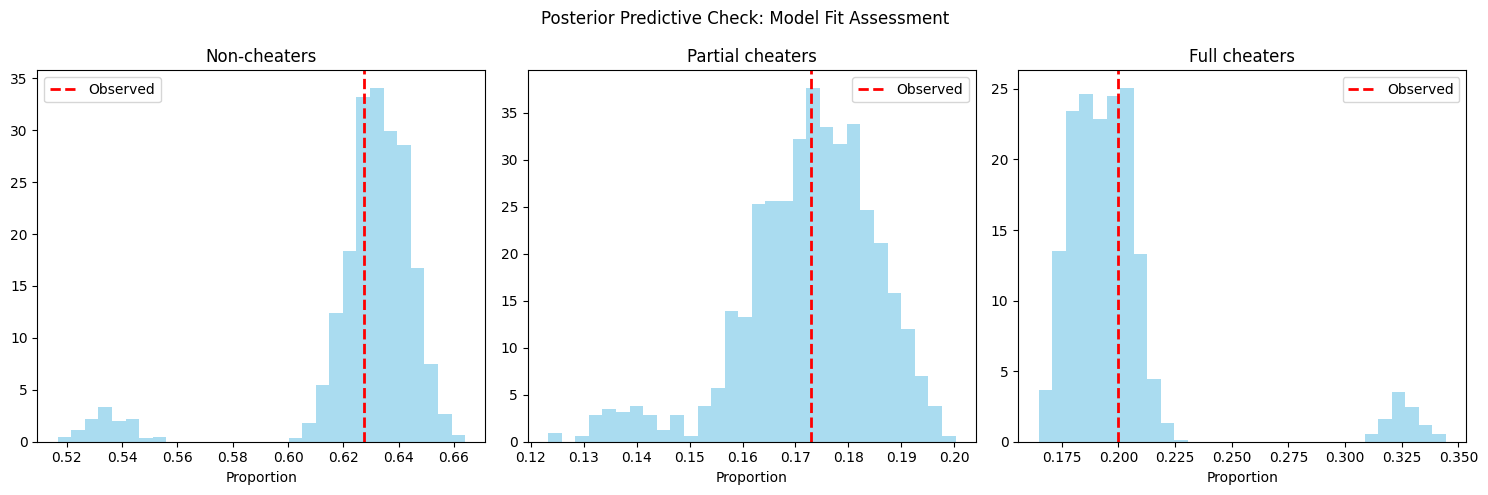

                         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_partial_intercept -1.368  0.256  -1.886   -0.934      0.038    0.021   
beta_full_intercept    -0.503  0.178  -0.854   -0.196      0.017    0.007   
mu_concept_partial      0.072  0.273  -0.437    0.581      0.046    0.026   
mu_concept_full        -0.691  0.186  -1.058   -0.360      0.013    0.007   
sigma_concept_partial   0.127  0.089   0.021    0.284      0.011    0.003   
sigma_concept_full      0.152  0.091   0.021    0.311      0.019    0.007   

                        ess_bulk  ess_tail  r_hat  
beta_partial_intercept      50.0      50.0   1.09  
beta_full_intercept        111.0     247.0   1.05  
mu_concept_partial          36.0      48.0   1.10  
mu_concept_full            194.0     384.0   1.05  
sigma_concept_partial       28.0      30.0   1.12  
sigma_concept_full          28.0      69.0   1.10  


In [7]:
# =============================================================================
# 4. MODEL DIAGNOSTICS
# =============================================================================

print("\n" + "="*50)
print("MODEL DIAGNOSTICS")
print("="*50)

# Posterior predictive checks
with cheating_model:
    ppc_cheating = pm.sample_posterior_predictive(trace_cheating, random_seed=42)

# Plot diagnostics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
y_obs = df['cheating_behavior'].values

for i, category in enumerate(['Non-cheaters', 'Partial cheaters', 'Full cheaters']):
    observed_prop = (y_obs == i).mean()
    predicted_props = (ppc_cheating.posterior_predictive['cheating_obs'] == i).mean(dim=['chain', 'draw'])
    
    axes[i].hist(predicted_props, bins=30, alpha=0.7, density=True, color='skyblue')
    axes[i].axvline(observed_prop, color='red', linestyle='--', linewidth=2, label='Observed')
    axes[i].set_title(f'{category}')
    axes[i].set_xlabel('Proportion')
    axes[i].legend()

plt.suptitle('Posterior Predictive Check: Model Fit Assessment')
plt.tight_layout()
plt.show()

# Model summary
print(az.summary(trace_cheating, var_names=['beta_partial_intercept', 'beta_full_intercept', 
                                           'mu_concept_partial', 'mu_concept_full',
                                           'sigma_concept_partial', 'sigma_concept_full']))


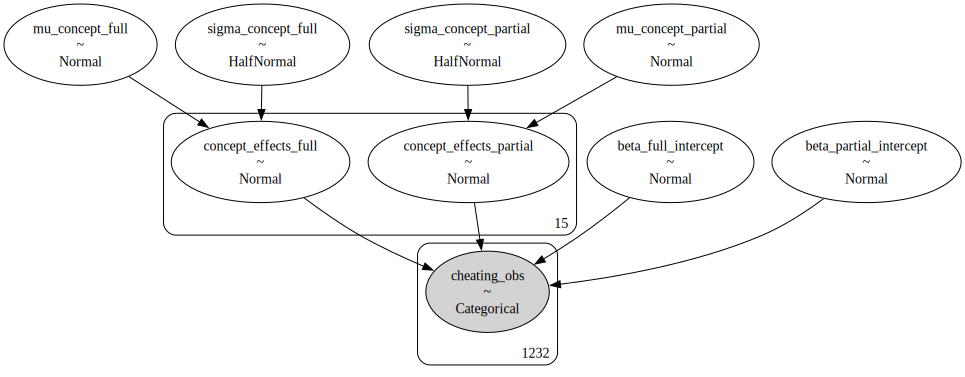

<Axes: xlabel='cheating_obs'>

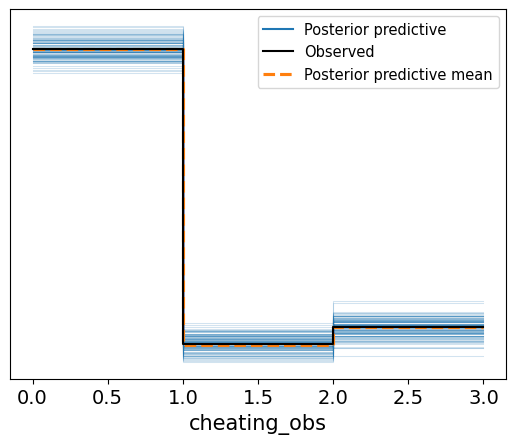

In [8]:
display(pm.model_to_graphviz(cheating_model))
display(az.plot_ppc(ppc_cheating, num_pp_samples=100))

In [9]:
# =============================
# SUMMARY OF RESULTS (Posteriors)
# =============================

# Calculate predicted probabilities with HDI
beta_partial_samples = trace_cheating.posterior['beta_partial_intercept'].values.flatten()
beta_full_samples = trace_cheating.posterior['beta_full_intercept'].values.flatten()
partial_effects = trace_cheating.posterior['concept_effects_partial'].values.reshape(-1, len(concepts))
full_effects = trace_cheating.posterior['concept_effects_full'].values.reshape(-1, len(concepts))

# Control group probabilities
control_logits = np.column_stack([
    np.zeros(len(beta_partial_samples)),
    beta_partial_samples,
    beta_full_samples
])
control_probs = np.exp(control_logits) / np.exp(control_logits).sum(axis=1, keepdims=True)

# Order concepts by theory
theory_order = [
    'autonomy', 'competence', 'relatedness',  # Self-Determination
    'self_concept', 'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction',  # Cognitive Dissonance
    'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal',  # Self-Efficacy
    'descriptive_norms', 'injunctive_norms', 'social_sanctions', 'reference_group_identification'  # Social Norms
]
theory_map = {
    'autonomy': 'Self-Determination Theory', 'competence': 'Self-Determination Theory', 'relatedness': 'Self-Determination Theory',
    'self_concept': 'Cognitive Dissonance Theory', 'cognitive_inconsistency': 'Cognitive Dissonance Theory', 
    'dissonance_arousal': 'Cognitive Dissonance Theory', 'dissonance_reduction': 'Cognitive Dissonance Theory',
    'performance_accomplishments': 'Self-Efficacy Theory', 'vicarious_experience': 'Self-Efficacy Theory', 
    'verbal_persuasion': 'Self-Efficacy Theory', 'emotional_arousal': 'Self-Efficacy Theory',
    'descriptive_norms': 'Social Norms Theory', 'injunctive_norms': 'Social Norms Theory', 
    'social_sanctions': 'Social Norms Theory', 'reference_group_identification': 'Social Norms Theory'
}

# Calculate differences for each concept with HDI
results_cheating = []
concept_differences = {}  # Store for reuse in forest plots

for concept in theory_order:
    if concept in concepts:
        i = concepts.index(concept)
        concept_logits = np.column_stack([
            np.zeros(len(beta_partial_samples)),
            beta_partial_samples + partial_effects[:, i],
            beta_full_samples + full_effects[:, i]
        ])
        concept_probs = np.exp(concept_logits) / np.exp(concept_logits).sum(axis=1, keepdims=True)
        
        # Differences with HDI
        non_diff = (concept_probs[:, 0] - control_probs[:, 0]) * 100
        partial_diff = (concept_probs[:, 1] - control_probs[:, 1]) * 100
        full_diff = (concept_probs[:, 2] - control_probs[:, 2]) * 100
        
        # Store for reuse
        concept_differences[concept] = {
            'non_diff': non_diff,
            'partial_diff': partial_diff,
            'full_diff': full_diff
        }
        
        results_cheating.append({
            'Concept': concept.replace('_', ' ').title(),
            'Theory': theory_map[concept],
            'Non_mean': non_diff.mean(),
            'Non_hdi': az.hdi(non_diff, hdi_prob=0.95),
            'Partial_mean': partial_diff.mean(),
            'Partial_hdi': az.hdi(partial_diff, hdi_prob=0.95),
            'Full_mean': full_diff.mean(),
            'Full_hdi': az.hdi(full_diff, hdi_prob=0.95)
        })

df_results = pd.DataFrame(results_cheating)

# Control baseline for labels
control_rates = {
    'Non': control_probs[:, 0].mean() * 100,
    'Partial': control_probs[:, 1].mean() * 100,
    'Full': control_probs[:, 2].mean() * 100
}

# Calculate overall intervention effects for reuse
overall_partial_effects = partial_effects.mean(axis=1)  
overall_full_effects = full_effects.mean(axis=1)

overall_logits = np.column_stack([
    np.zeros(len(beta_partial_samples)),
    beta_partial_samples + overall_partial_effects,
    beta_full_samples + overall_full_effects
])
overall_probs = np.exp(overall_logits) / np.exp(overall_logits).sum(axis=1, keepdims=True)

overall_results = {}
for i, category in enumerate(['Non', 'Partial', 'Full']):
    diff = (overall_probs[:, i] - control_probs[:, i]) * 100
    overall_results[category] = {
        'mean': diff.mean(),
        'hdi': az.hdi(diff, hdi_prob=0.95)
    }

# Print with HDI
print("Cheating Behavior Changes (percentage points) with 95% HDI:")
print(f"{'Concept':<35} {'Theory':<30} {'Non-cheater':<25} {'Partial':<25} {'Full':<25}")
print("-" * 130)
for _, row in df_results.iterrows():
    non_str = f"{row['Non_mean']:+.1f} [{row['Non_hdi'][0]:+.1f}, {row['Non_hdi'][1]:+.1f}]"
    partial_str = f"{row['Partial_mean']:+.1f} [{row['Partial_hdi'][0]:+.1f}, {row['Partial_hdi'][1]:+.1f}]"
    full_str = f"{row['Full_mean']:+.1f} [{row['Full_hdi'][0]:+.1f}, {row['Full_hdi'][1]:+.1f}]"
    print(f"{row['Concept']:<35} {row['Theory']:<30} {non_str:<25} {partial_str:<25} {full_str:<25}")


Cheating Behavior Changes (percentage points) with 95% HDI:
Concept                             Theory                         Non-cheater               Partial                   Full                     
----------------------------------------------------------------------------------------------------------------------------------
Autonomy                            Self-Determination Theory      +10.3 [+1.6, +18.3]       +4.1 [-2.3, +11.4]        -14.4 [-22.7, -5.9]      
Competence                          Self-Determination Theory      +9.8 [-0.8, +17.7]        +2.6 [-3.5, +10.4]        -12.5 [-21.2, -4.2]      
Relatedness                         Self-Determination Theory      +9.6 [-0.5, +17.4]        +2.5 [-3.5, +10.2]        -12.1 [-20.8, -3.7]      
Self Concept                        Cognitive Dissonance Theory    +10.0 [+1.3, +18.5]       +3.5 [-2.4, +11.1]        -13.5 [-22.0, -5.1]      
Cognitive Inconsistency             Cognitive Dissonance Theory    +10.3 [+0.2, +17.

In [ ]:
categories = ['Non', 'Partial', 'Full']
titles = ['Non-cheater Rate Change', 'Partial Cheater Rate Change', 'Full Cheater Rate Change']

# PLOT 1: Overall intervention effect (reuse overall_results)
fig1, axes1 = plt.subplots(1, 3, figsize=(14, 4))

for idx, (cat, title) in enumerate(zip(categories, titles)):
    ax = axes1[idx]
    
    mean = overall_results[cat]['mean']
    hdi = overall_results[cat]['hdi']
    
    ax.plot([hdi[0], hdi[1]], [0, 0], color='black', linewidth=3)
    ax.plot(mean, 0, 's', color='black', markersize=12)
    
    ax.text(mean, -0.15, f'{mean:+.1f}\n[{hdi[0]:+.1f}, {hdi[1]:+.1f}]', 
            ha='center', va='center', fontweight='bold', fontsize=12)
    
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)
    
    if idx == 0:
        ax.set_yticks([0])
        ax.set_yticklabels(['Overall Intervention Effect'], fontsize=14, fontweight='bold')
    else:
        ax.set_yticks([])
    
    ax.tick_params(axis='x', labelsize=14)
    ax.set_xlabel(f'Percentage Point Change from \nControl ({control_rates[cat]:.1f}%)', fontsize=14)
    ax.set_title(title, fontweight='bold', fontsize=16, pad=20)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.3, 0.3)
    
    xlim = ax.get_xlim()
    if cat == 'Non':
        ax.text(xlim[0] * 0.8, 0.25, 'More Cheating', ha='center', va='center', fontsize=12, style='italic')
        ax.text(xlim[1] * 0.8, 0.25, 'Less Cheating', ha='center', va='center', fontsize=12, style='italic')
    else:
        ax.text(xlim[0] * 0.8, 0.25, 'Less Cheating', ha='center', va='center', fontsize=12, style='italic')
        ax.text(xlim[1] * 0.8, 0.25, 'More Cheating', ha='center', va='center', fontsize=12, style='italic')

plt.suptitle('Overall Intervention Effect: Concept-Based Messages Increase Honest\nTest-Taking by ~12% while Reducing Full Cheating by ~11%', 
                fontsize=18, fontweight='bold', color="black", alpha=0.7, y=0.97)
plt.tight_layout()
plt.subplots_adjust(top=0.6)
plt.show()

# PLOT 2: By-concept effects (reuse df_results)
import matplotlib.patches as patches

fig2, axes2 = plt.subplots(1, 3, figsize=(16, 10))

theory_order_viz = ['Self-Determination Theory', 'Cognitive Dissonance Theory', 'Self-Efficacy Theory', 'Social Norms Theory'][::-1]
theory_colors = {'Self-Determination Theory': "#007C36", 'Cognitive Dissonance Theory': '#4B0082',
                    'Self-Efficacy Theory': '#DC143C', 'Social Norms Theory': "#C06900"}

df_results['Theory'] = pd.Categorical(df_results['Theory'], categories=theory_order_viz, ordered=True)
df_results_sorted = df_results.sort_values(['Theory', 'Concept']).reset_index(drop=True)

for idx, (cat, title) in enumerate(zip(categories, titles)):
    ax = axes2[idx]
    means = df_results_sorted[f'{cat}_mean'].values
    hdis = np.array([row[f'{cat}_hdi'] for _, row in df_results_sorted.iterrows()])
    
    y_positions = np.arange(len(df_results_sorted))
    
    # Highlight best concept per theory
    highlight_indices = []
    for theory in theory_order_viz:
        indices = df_results_sorted.index[df_results_sorted['Theory'] == theory].tolist()
        if indices:
            theory_means = means[indices]
            target_idx = indices[np.argmax(theory_means)] if cat == 'Non' else indices[np.argmin(theory_means)]
            highlight_indices.append(target_idx)
    
    # Background shading and forest plot
    for theory in theory_order_viz:
        indices = df_results_sorted.index[df_results_sorted['Theory'] == theory].tolist()
        if indices:
            ax.axhspan(indices[0]-0.5, indices[-1]+0.5, alpha=0.1, color=theory_colors[theory])
    
    for i in range(len(df_results_sorted)):
        color = theory_colors[df_results_sorted.iloc[i]['Theory']]
        alpha = 1.0 if i in highlight_indices else 0.4
        ax.plot([hdis[i][0], hdis[i][1]], [i, i], color=color, alpha=alpha, linewidth=2)
        ax.plot(means[i], i, 's', color=color, alpha=alpha, markersize=8)
    
    # Overall estimate diamond
    overall_mean = means.mean()
    overall_se = np.std(means) / np.sqrt(len(means))
    diamond_y = len(df_results_sorted) + 0.5
    diamond_x = [overall_mean - 1.96*overall_se, overall_mean, overall_mean + 1.96*overall_se, overall_mean, overall_mean - 1.96*overall_se]
    diamond_y_coords = [diamond_y, diamond_y + 0.2, diamond_y, diamond_y - 0.2, diamond_y]
    ax.fill(diamond_x, diamond_y_coords, color='black', alpha=0.7)
    
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)

    if idx == 0:
        ax.set_yticks(list(y_positions) + [diamond_y])
        y_labels = df_results_sorted['Concept'].tolist() + ['Overall estimate']
        ax.set_yticklabels(y_labels, fontsize=14, fontweight='bold')

        for tick_label, concept in zip(ax.get_yticklabels()[:-1], df_results_sorted['Concept']):
            theory = df_results_sorted.loc[df_results_sorted['Concept'] == concept, 'Theory'].values[0]
            tick_label.set_color(theory_colors[theory])
        ax.get_yticklabels()[-1].set_color('black')
    else:
        ax.set_yticks([])

    ax.tick_params(axis='x', labelsize=14)
    ax.set_xlabel(f'Percentage Point Change from \nControl ({control_rates[cat]:.1f}%)', fontsize=14)
    ax.set_title(title, fontweight='bold', fontsize=16, pad=20)
    ax.grid(True, alpha=0.3)
    
    xlim = ax.get_xlim()
    if cat == 'Non':
        ax.text(xlim[0] * 0.8, len(df_results_sorted) + 1, 'Less Cheating', ha='center', va='center', fontsize=12, style='italic')
        ax.text(xlim[1] * 0.8, len(df_results_sorted) + 1, 'More Cheating', ha='center', va='center', fontsize=12, style='italic')
    else:
        ax.text(xlim[0] * 0.8, len(df_results_sorted) + 1, 'More Cheating', ha='center', va='center', fontsize=12, style='italic')
        ax.text(xlim[1] * 0.8, len(df_results_sorted) + 1, 'Less Cheating', ha='center', va='center', fontsize=12, style='italic')

legend_elements = [patches.Patch(color=color, label=f"Concepts of {theory}") for theory, color in theory_colors.items()]
fig2.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=2, fontsize=14)

plt.suptitle('Message Related to \'Reference Group Identification\' Most Increases Honest \nTest-Taking Overall. Messages Focusing on \'Cognitive Inconsistency\' and \'Verbal\n Persuasion\' Can Reduce Full Cheating, While Effects on Partial Cheating Are Minimal', 
            fontsize=20, fontweight='bold', color='black', alpha=0.7, y=0.95)

plt.tight_layout()
plt.subplots_adjust(top=0.75, bottom=0.1)
plt.show()
